In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Bidirectional
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import string
import pickle

# Import and Load the Dataset

In [2]:
path = "jsonformatter.txt"

with open(path) as content:
  data1 = json.load(content)

# print(data1)

In [3]:
tag = []
patterns = []
responses = {}

#getting all data to list
for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['patterns']:
    patterns.append(lines)
    tag.append(intent['tag'])



In [4]:
# convert to dataframe
data = pd.DataFrame({'patterns':patterns,
                     'tags': tag})

In [5]:
#print
data.sample(n=10)

,patterns,tags
189,visi misi dari perpustakaan ummi?,UPT Perpustakaan
155,Informasi terkait lembaga al islam kemuhammadi...,Lembaga Al-Islam Kemuhammadiyahan
125,Visi Misi Tujuan dan Sasaran yang dimiliki ummi?,"Visi, Misi, Tujuan dan Sasaran Universitas Muh..."
164,Apa itu dewan penyantun?,Dewan Penyantun
76,ada beasiswa apa saja?,Beasiswa
100,Berapa biaya untuk kelas reguler dan non reguler?,Rincian Biaya
220,bagaimana cara melakukan pindah program progra...,Perpindahan Program Studi atau Fakultas
390,saintek ummi,SAINTEK
10,Dadah,bye
204,boleh minta pedoman administrasi akademik?,Pedoman Administrasi Akademik


# Preprocessing Data

### Remove Punctuation and LowerCase

Pada tahap ini semua tanda baca pada "patterns" akan diubah ke lowercase dan punctuantion dihilangkan

In [6]:
def data_cleaning(data):
  data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
  data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
  return data
dirty_text = pd.DataFrame({'patterns':patterns})
clean_text = pd.DataFrame({'patterns':patterns})
result = pd.concat([dirty_text['patterns'], data_cleaning(clean_text)], axis=1)
result

,patterns,patterns
0,Hai,hai
1,Hi,hi
2,Halo,halo
3,Apa Kabar,apa kabar
4,Selamat Pagi!,selamat pagi
...,...,...
421,arti lambang,arti lambang
422,makna lambang,makna lambang
423,lagu ummi,lagu ummi
424,mars ummi,mars ummi


## Word Normalization
Tahap ini digunakan untuk merubakah kata yang tidak baku menjadi kata baku

In [7]:
# corpus bisa didownload pada link dibawah ini
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

clean_text['patterns'] = clean_text['patterns'].apply(text_normalize)
result = pd.concat([dirty_text['patterns'], clean_text['patterns']], axis=1)
result

#print(text_normalize('agk'))

,patterns,patterns
0,Hai,hai
1,Hi,hi
2,Halo,halo
3,Apa Kabar,apa kabar
4,Selamat Pagi!,selamat pagi
...,...,...
421,arti lambang,arti lambang
422,makna lambang,makna lambang
423,lagu ummi,lagu ummi
424,mars ummi,mars ummi


### Stopword Removal
Stopword removal adalah proses penghapusan atau penghilangan kata-kata umum yang tidak memiliki makna khusus atau tidak memberikan kontribusi signifikan dalam pemrosesan teks atau analisis NLP (Natural Language Processing). Stopword biasanya terdiri dari kata-kata seperti "ada", "di", "dan", "yang", dan sebagainya. Kata-kata ini muncul secara berulang dalam teks dan tidak memberikan informasi yang berguna dalam pemahaman konten.

In [9]:
#Stopword download from nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MRizky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
len(stopwords_ind)

758

In [11]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:10]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir']

In [12]:
# Menambahkan kata dalam stopword
more_stopword = ['kak', 'informasi', "tentang"]
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

clean_text['patterns'] = clean_text['patterns'].apply(remove_stop_words)
result = pd.concat([dirty_text['patterns'], clean_text['patterns']], axis=1)
result

,patterns,patterns
0,Hai,hai
1,Hi,hi
2,Halo,halo
3,Apa Kabar,kabar
4,Selamat Pagi!,selamat pagi
...,...,...
421,arti lambang,arti lambang
422,makna lambang,makna lambang
423,lagu ummi,lagu ummi
424,mars ummi,mars ummi


### Stemming
Stemming adalah proses mengubah kata-kata menjadi bentuk dasarnya (stem) dengan menghapus awalan atau akhiran kata. untuk melakukan stemming, disini saya menggunakan library sastrawi

In [13]:
!pip -q install sastrawi


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
#Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

clean_text['patterns'] = clean_text['patterns'].apply(stemming)
result = pd.concat([dirty_text['patterns'], clean_text['patterns']], axis=1)
result

,patterns,patterns
0,Hai,hai
1,Hi,hi
2,Halo,halo
3,Apa Kabar,kabar
4,Selamat Pagi!,selamat pagi
...,...,...
421,arti lambang,arti lambang
422,makna lambang,makna lambang
423,lagu ummi,lagu ummi
424,mars ummi,mars ummi


In [15]:
def text_preprocessing_process(text):
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [16]:
data['patterns'] = data['patterns'].apply(text_preprocessing_process)
data

,patterns,tags
0,hai,salam
1,hi,salam
2,halo,salam
3,kabar,salam
4,selamat pagi,salam
...,...,...
421,arti lambang,identitas
422,makna lambang,identitas
423,lagu ummi,mars ummi
424,mars ummi,mars ummi


### Tokenize
Tokenizer mengidentifikasi dan memisahkan teks menjadi token-token yang dapat diolah lebih lanjut. Ini dapat berupa tokenisasi berbasis kata, di mana teks dipisahkan menjadi kata-kata individual, atau tokenisasi berbasis sub-kata, di mana teks dipisahkan menjadi unit-unit yang lebih kecil seperti akar kata atau bagian-bagian kata.

### Sequence and Padding
- Sequence (urutan) merujuk pada representasi linier dari teks atau urutan kata dalam bentuk vektor. Dalam pemrosesan bahasa alami, teks sering kali dipecah menjadi urutan kata atau token, dan urutan ini dapat dianggap sebagai rangkaian langkah yang harus diikuti dalam pemodelan dan analisis teks.
- Padding adalah proses menambahkan nilai khusus (biasanya nilai nol) ke urutan teks sehingga semua urutan memiliki panjang yang sama. Ini diperlukan karena teks biasanya memiliki panjang yang berbeda-beda, sementara banyak model pemrosesan bahasa alami memerlukan masukan dengan ukuran yang seragam. Dengan padding, teks yang lebih pendek diisi dengan nilai nol hingga mencapai panjang yang diinginkan.

In [17]:
#tokenize
trunc_type='post'
padding_type='post'


tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])

# print(tokenizer)

# Get the word index dictionary
word_index = tokenizer.word_index

#applying padding
x_train = pad_sequences(train, padding=padding_type, truncating=trunc_type)



In [18]:
#encoding the methods
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

# print("\nWord Index = " , word_index)
# print("\nSequences = " , train)
# print(x_train)
# print(le)
print(y_train)


[ 98  98  98  98  98  98  98  98  98  98  88  88  88  88  88  88  88  88
  88  88  88  89  89  89  89  89  89  89  89  89  89  89  89  89  89  31
  31  31  31  31  31  66  66  66  66  66  66  66  66  66  66  66  66  66
  43  43  43  99  99  99  71  71  71   7   7   7  26  26  26  94  94  94
  94  94   9   9   9   9   9   9   9   9   9   9   9   9  70  70  70  70
  70  70  70  69  69  12  12  12  12  12  72  72  72  72  72  72  72  72
  37  37  37  37  37  37  37  83  83  83  83  83  83  83  87  87  87  87
  87  80  80  80  80  67  67  67  67  67  67  41  41  41  41  41  41  25
  25  25  25  25  40  40  40  40  40  38  38  38  38  38   8   8   8   8
   8   8  15  15  15  15  15  15  39  39  39  39  39  39  39  79  84  84
  84  84  84  84  84  85  85  85  86  86  86  76  76  17  18  29  28  34
  34  34  34  50  50  50  50  51  51  51  51  51  51  51  51  10  10  10
   2   2   2  65  65  65  65  65  65  65  65  68  68  68  97  97  97  97
  97  97  97  62  62  62  62  33  33  33  33  33  6

In [19]:
daftar = reverse_word_index = dict((value, key) for (key, value) in tokenizer.word_index.items())
print(daftar)

{1: 'ummi', 2: 'bayar', 3: 'daftar', 4: 'program', 5: 'bank', 6: 'pindah', 7: 'fakultas', 8: 'studi', 9: 'kuliah', 10: 'beasiswa', 11: 'kampus', 12: 'tahap', 13: 'visi', 14: 'misi', 15: 'tugas', 16: 'adalah', 17: 'reguler', 18: 'surat', 19: 'biaya', 20: 'lembaga', 21: 'muhammadiyah', 22: 'didik', 23: 'non', 24: 'akademik', 25: 'universitas', 26: 'sukabumi', 27: 'sedia', 28: 'jurus', 29: 'sarjana', 30: 'kip', 31: 'kelas', 32: 'ya', 33: 'syarat', 34: 'administrasi', 35: 'ilmu', 36: 'mahasiswa', 37: 'mana', 38: 'upt', 39: 'dewan', 40: 'santun', 41: 'pmb', 42: 'terang', 43: 'ada', 44: 'aja', 45: 'jadwal', 46: 'kak', 47: '1', 48: 'semester', 49: 'rektor', 50: 'fasilitas', 51: 'al', 52: 'islam', 53: 'kemuhammadiyahan', 54: 'bph', 55: 'lppm', 56: 'aktif', 57: 'ijazah', 58: 'paja', 59: 'manajemen', 60: 'retail', 61: 'selamat', 62: 'terima', 63: 'prodi', 64: 'saja', 65: 'transfer', 66: 'profesi', 67: 'ners', 68: 'hubung', 69: 'struktur', 70: 'organisasi', 71: 'wakil', 72: 'humas', 73: 'giat', 7

In [20]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [21]:
vocabulary = len(tokenizer.word_index)
print('number of unique words : ', vocabulary)
output_length = le.classes_.shape[0]
print('output length', output_length)

number of unique words :  313
output length 101


In [22]:
#creating model
# i = Input(shape=(input_shape,))
# x = Embedding(vocabulary+1,10)(i) #vocabsize, dimensi, input
# x = LSTM(10, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(output_length, activation='softmax')(x)
# model = Model(i,x)

model = Sequential([
    Embedding(input_dim=vocabulary+1, output_dim=10, input_length=input_shape),
    Bidirectional(LSTM(10)),
    Flatten(),
    Dense(output_length, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 10)             3140      
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1680      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 101)               2121      
                                                                 
Total params: 6,941
Trainable params: 6,941
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200


14/14 [==============================] - 6s 7ms/step - loss: 4.6138 - accuracy: 0.0164
Epoch 2/200
14/14 [==============================] - 0s 7ms/step - loss: 4.6073 - accuracy: 0.0376
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 4.6006 - accuracy: 0.0376
Epoch 4/200
14/14 [==============================] - 0s 8ms/step - loss: 4.5920 - accuracy: 0.0329
Epoch 5/200
14/14 [==============================] - 0s 7ms/step - loss: 4.5806 - accuracy: 0.0329
Epoch 6/200
14/14 [==============================] - 0s 8ms/step - loss: 4.5639 - accuracy: 0.0329
Epoch 7/200
14/14 [==============================] - 0s 7ms/step - loss: 4.5402 - accuracy: 0.0329
Epoch 8/200
14/14 [==============================] - 0s 7ms/step - loss: 4.5056 - accuracy: 0.0329
Epoch 9/200
14/14 [==============================] - 0s 7ms/step - loss: 4.4705 - accuracy: 0.0329
Epoch 10/200
14/14 [==============================] - 0s 7ms/step - loss: 4.4336 - accuracy: 0.0329
Epoch 11/200
14/14 [=

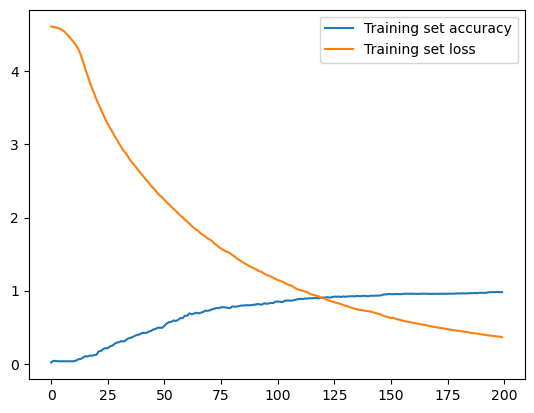

In [26]:
#Model Analysis
plt.plot(train.history['accuracy'], label = 'Training set accuracy')
plt.plot(train.history['loss'], label = 'Training set loss')
plt.legend()

In [27]:
#testing
import random
import numpy as np
import string

print("Selamat datang, ada yang ingin ditanyakan?")
while True:
  texts_p = []
  prediction_input = input('you : ')
  #removing punctuation
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  prediction_input = text_preprocessing_process(prediction_input)
  texts_p.append(prediction_input)

  print("text_p",texts_p)
  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  print("p1",prediction_input)
  prediction_input = np.array(prediction_input).reshape(-1)
  print('p2',prediction_input)
  prediction_input = pad_sequences([prediction_input],input_shape, padding=padding_type, truncating=trunc_type)
  print('p3',prediction_input)


  #output
  output = model.predict(prediction_input)
  max_prob = max(model.predict(prediction_input))
  print('max_prob', max_prob)
  print('out1',output)
  max_idx = np.argmax(output)
  print('maxidx', max_idx)
  output = output.argmax()
  print('out',output)


  #finding the right tag and predicting
  if sum(np.array(prediction_input).reshape(-1)) < 1:
    print("Maaf saya tidak mengerti")
  else:
    response_tag = le.inverse_transform([output])[0]
    print(response_tag)
    print("answer : " ,random.choice(responses[response_tag]))
  if response_tag == 'bye':
    break




Selamat datang, ada yang ingin ditanyakan?
text_p ['beasiswa khusus mahasiswa asal latar ekonomi beasiswa kip kartu indonesia pintar']
p1 [[10, 36, 172, 10, 30, 97, 166, 290]]
p2 [ 10  36 172  10  30  97 166 290]
p3 [[ 10  36 172  10  30  97 166]]
1/1 [==============================] - 0s 30ms/step
max_prob [9.4266601e-05 9.5971499e-04 1.9308070e-05 7.1159384e-06 3.8985750e-03
 6.7511239e-05 7.6686090e-05 5.9404741e-05 3.3927447e-04 2.5485891e-01
 7.2047333e-05 1.0137175e-05 1.3775432e-04 4.5664606e-04 8.4412759e-06
 1.0259991e-03 7.8786322e-04 1.7044807e-05 5.0538062e-04 9.1060251e-04
 1.4134442e-05 2.5475365e-06 5.6461147e-05 4.7731644e-04 2.2792381e-05
 2.1854951e-04 8.9254419e-05 1.1273824e-04 3.9710190e-05 1.3958372e-03
 2.8082563e-06 3.9347881e-03 7.9352021e-02 2.1695921e-03 9.3660434e-04
 2.4640188e-04 2.1929149e-05 6.0530257e-04 2.1534350e-05 2.3159094e-04
 2.8787028e-05 2.1157166e-05 4.6996921e-04 4.5394921e-04 2.1042390e-05
 5.4847951e-05 1.5082633e-06 5.0396220e-06 9.7485242

In [28]:
#pickle.dump(model, open('model.pkl', 'wb'))

In [29]:
#model.save("chat_model")

In [30]:
import tensorflow as tf
import numpy as np

# Data teks
texts = ["Ini adalah contoh", "Teks simulasi", "Layer Embedding"]

# Membuat kamus kata (vocabulary)
vocab = set()
for text in texts:
    for word in text.split():
        vocab.add(word)
vocab_size = len(vocab)

# Menginisialisasi model Sequential
model = tf.keras.Sequential()

# Menambahkan layer Embedding
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=10, input_length=None))

# Mengkompilasi model
model.compile(optimizer='adam', loss='mse')

# Mengubah teks menjadi representasi numerik menggunakan layer Embedding
embedded_texts = model.predict(np.arange(vocab_size).reshape(1, -1))

print("Representasi Teks:")
print(embedded_texts)
print("Shape:", embedded_texts.shape)


1/1 [==============================] - 0s 72ms/step
Representasi Teks:
[[[ 0.0271746  -0.01388965  0.04970212  0.00099305  0.01578298
   -0.03087476 -0.03044762  0.04544604  0.0145372   0.00603244]
  [ 0.04030636 -0.00835653  0.04774607 -0.01752468  0.02100911
   -0.01548517  0.03869387  0.03366816 -0.02815311 -0.04288037]
  [-0.04677103 -0.00483539  0.03072976 -0.04897115 -0.04106677
   -0.02521222 -0.00312997  0.03835069 -0.04686505 -0.03426092]
  [ 0.0381225  -0.04895562  0.03300161  0.03486792  0.03235448
   -0.02310358 -0.00624539  0.00861027  0.02985782  0.03518771]
  [ 0.03783439  0.00604381 -0.04441028  0.00545185 -0.04104888
   -0.02358576 -0.04518035 -0.02734341  0.00394312  0.03543533]
  [ 0.02207914  0.04454098  0.01373709 -0.01032069  0.03991211
   -0.04211561 -0.02669528  0.01848837 -0.01784427 -0.01674648]
  [ 0.02965374  0.0394134   0.00217264 -0.0416334   0.03368691
   -0.02156303 -0.00444321  0.0032645   0.04325571 -0.03983271]]]
Shape: (1, 7, 10)
